In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# pip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

# tk libs
from teslakit.project_site import Site
from teslakit.io.matlab import ReadNakajoMats
from teslakit.util.operations import GetUniqueRows
from teslakit.storms import Extract_Circle_Nakajo, SortCategoryCount


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN_TEST')

DB = site.pc.DB                        # common database
ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files
p_nakajo_mats = DB.TCs.nakajo_mats     # Nakajo synthetic TCs

# output files
p_probs_synth = ST.TCs.probs_synth     # TCs category change probabilities

# wave point lon, lat, and radius for TC selection
pnt_lon = float(PR.WAVES.point_longitude)
pnt_lat = float(PR.WAVES.point_latitude)
r1 = float(PR.TCS.r1)                   # bigger one
r2 = float(PR.TCS.r2)                   # smaller one


In [2]:
# --------------------------------------
# read each nakajo simulation pack from .mat custom files 
xds_Nakajo = ReadNakajoMats(p_nakajo_mats)

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'pressure':'yCPRES',
}


# Extract synthetic TCs at 2 radius to get category change 
print(
'\nExtracting Synthetic TCs from Nakajo database...\n \
Lon = {0:.2f}º , Lat = {1:.2f}º\n \
R1  = {2:6.2f}º , R2  = {3:6.2f}º'.format(
    pnt_lon, pnt_lat, r1, r2)
)

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle_Nakajo(
    xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle_Nakajo(
    xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print(xds_in_r1)
print('')
print(xds_in_r2)



Extracting Synthetic TCs from Nakajo database...
 Lon = 167.50º , Lat = 9.75º
 R1  =  14.00º , R2  =   4.00º
<xarray.Dataset>
Dimensions:       (storm: 63036)
Coordinates:
  * storm         (storm) int64 5 8 14 50 52 ... 999974 999982 999986 999990
Data variables:
    pressure_min  (storm) float64 983.2 932.8 960.5 978.9 ... 968.4 975.2 992.4
    category      (storm) int64 1 4 3 2 1 0 0 0 2 1 5 ... 0 4 1 2 1 1 4 0 2 2 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    14.0

<xarray.Dataset>
Dimensions:       (storm: 12839)
Coordinates:
  * storm         (storm) int64 5 296 299 387 ... 999846 999877 999982 999986
Data variables:
    pressure_min  (storm) float64 988.1 961.0 998.7 ... 976.4 1.007e+03 998.5
    category      (storm) int64 1 3 1 1 2 4 0 2 0 0 1 ... 3 1 2 3 2 1 1 0 2 0 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    4.0


In [3]:
print('\nCalculating Syntethic TCs category-change probabilities...')

# Get min pressure and storm category inside both circles
n_storms = len(xds_in_r1.storm)
categ_r1r2 = np.empty((n_storms, 2))
for i in range(len(xds_in_r1.storm)):

    # min pressure inside R1
    storm_in_r1 = xds_in_r1.isel(storm=[i])
    storm_id = storm_in_r1.storm.values[0]
    storm_cat_r1 = storm_in_r1.category

    # min pressure inside R2
    if storm_id in xds_in_r2.storm.values[:]:
        storm_in_r2 = xds_in_r2.sel(storm=[storm_id])
        storm_cat_r2 = storm_in_r2.category
    else:
        storm_cat_r2 = 9  # no category 

    # store categories
    categ_r1r2[i,:] = [storm_cat_r1, storm_cat_r2]


# count category changes and sort it
categ_count = GetUniqueRows(categ_r1r2)
categ_count = SortCategoryCount(categ_count)

# calculate probability
m_count = np.reshape(categ_count[:,2], (6,-1)).T
m_sum = np.sum(m_count,axis=0)

probs = m_count.astype(float)/m_sum.astype(float)
probs_cs = np.cumsum(probs, axis=0)
print(probs)

# store output using xarray
xds_categ_cp = xr.Dataset(
    {
        'category_change_count': (('category','category'), m_count[:-1,:]),
        'category_change_sum': (('category'), m_count[-1,:]),
        'category_change_probs': (('category','category'), probs[:-1,:]),
        'category_nochange_probs': (('category'), probs[-1,:]),
        'category_change_cumsum': (('category','category'), probs_cs[:-1,:]),
    },
    coords = {
        'category': [0,1,2,3,4,5]
    }
)
xds_categ_cp.to_netcdf(p_probs_synth)
print(xds_categ_cp)
print('\nSyntethic TCs category-change stored at:\n{0}'.format(p_probs_synth))



Calculating Syntethic TCs category-change probabilities...
[[8.24718794e-02 6.14538385e-02 5.21140610e-02 2.69662921e-02
  1.04068117e-02 2.50000000e-04]
 [0.00000000e+00 5.99364598e-02 2.00393314e-01 2.61123596e-01
  1.65326395e-01 1.40000000e-02]
 [0.00000000e+00 0.00000000e+00 1.69124877e-02 7.83520599e-02
  2.26584674e-01 3.72500000e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.28838951e-03
  1.50189215e-01 1.25000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.46641438e-02 1.24250000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.47250000e-01]
 [9.17528121e-01 8.78609702e-01 7.30580138e-01 6.24269663e-01
  4.32828761e-01 4.52000000e-01]]
<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 1811 1296 265 ... 0 989
    category_change_sum      (category) int64 2

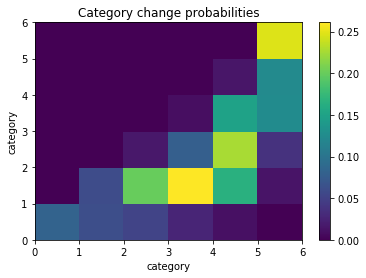

In [4]:
# plot category change probabilities
cp = xds_categ_cp.category_change_probs.values[:]
cs = xds_categ_cp.category.values[:]

fig, axes = plt.subplots()
axes.set_title('Category change probabilities')
axes.set_xlabel('category')
axes.set_ylabel('category')
pc=axes.pcolor(cp)
fig.colorbar(pc)

plt.show()
